In [63]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import sqlite3
import os
import json
"""
Filepaths
"""
db_files_path_low = 'database_files_lower_rho/'
db_files_path_mid = 'database_files_mid_rho/'
db_files_path_high = 'database_files_higher_rho/'
CREDIT_RATING_FILEPATH = 'dependencies/sp_global_ratings_default.json'

db_file_paths_list_low = []
for i in os.listdir(db_files_path_low):
    db_file_paths_list_low.append(os.path.abspath(db_files_path_low+i))
    
db_file_paths_list_mid = []
for i in os.listdir(db_files_path_mid):
    db_file_paths_list_mid.append(os.path.abspath(db_files_path_mid+i))

db_file_paths_list_high = []
for i in os.listdir(db_files_path_high):
    db_file_paths_list_high.append(os.path.abspath(db_files_path_high+i))

text_for_graphs_low = "rho(0.12) \n"
text_for_graphs_mid = "rho(0.16) \n"
text_for_graphs_high = "rho(0.24) \n"

"""
For graphs
"""
colormapping = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 
                '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

def loss_density(x, p, rho):
    N_inv_x = norm.ppf(x)
    N_inv_p = norm.ppf(p)
    factor = np.sqrt(1 - rho) / np.sqrt(rho)
    exp_term = - (1 / (2 * rho)) * ((np.sqrt(1 - rho) * N_inv_x - N_inv_p) ** 2) + 0.5 * (N_inv_x ** 2)
    density = factor * np.exp(exp_term)
    return density

def loss_dist_cdf(x, pd, rho):
    return norm.cdf((np.sqrt(1 - rho) * norm.ppf(x) - norm.ppf(pd)) / (np.sqrt(rho)))

def valueAtRisk(alpha, pd, rho):
    return loss_dist_cdf(alpha, 1-pd, 1-rho)

def loss_mode(p, rho):
    N_inv_p = norm.ppf(p)
    mode_argument = (np.sqrt(1 - rho) * N_inv_p) / (1 - 2 * rho)
    L_mode = norm.cdf(mode_argument)
    return L_mode


def create_df(pd_CDF, rho=0.16):

    df = pd.DataFrame()
    
    df['probability_CDF'] = np.arange(0.001, 1, 0.001)
    
    df['prob_PPF'] = df['probability_CDF'].apply(lambda x: norm.ppf(x))
    
    df['cumulative_portfolio_loss_dist'] = df['probability_CDF'].apply(
        lambda x: norm.cdf((np.sqrt(1 - rho) * norm.ppf(x) - norm.ppf(pd_CDF)) / np.sqrt(rho)))
    
    df['loan_losses'] = df['probability_CDF'].apply(
        lambda x: norm.cdf((np.sqrt(1 - rho) * norm.ppf(x) - norm.ppf(pd_CDF)) / (np.sqrt(rho))))
    
    df['cpol'] = df['probability_CDF'].apply(
        lambda x: norm.cdf((norm.ppf(pd_CDF) - norm.ppf(x) * np.sqrt(rho)) / np.sqrt(1 - rho)))
    
    df['sym_prop'] = df['probability_CDF'].apply(lambda x: 1 if x > pd_CDF else (0.5 if x==pd_CDF else 0))
    df['density'] = df['probability_CDF'].apply(lambda x: loss_density(x, pd_CDF, rho))
    
    return df

def fetch_table_data_to_df(db_filepath, query):
    try:
        # Connect to the database file
        conn = sqlite3.connect(db_filepath, isolation_level=None,
                                detect_types=sqlite3.PARSE_COLNAMES)
        cursor = conn.cursor()
        # Get all data from the table
        cursor.execute(f"{query} FROM 'simulation'")
        #headers = [info[1] for info in cursor.fetchall()]
        headers = [i[0] for i in cursor.description]

        print(f"Following columns in a dataframe {headers}")

        data = cursor.fetchall()

        # Convert to DataFrame
        df = pd.DataFrame(data, columns=headers)

        return df
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()
    
    finally:
        conn.close()

def all_years_df_per_grade(db_file_list, grade):
    df = pd.DataFrame()
    df["Y"] = fetch_table_data_to_df(db_file_list[0], "SELECT Y")
    
    for i in db_file_list:
        column_suffix = (''.join(filter(str.isdigit, i)))
        df[grade+column_suffix] = fetch_table_data_to_df(i, "SELECT "+grade)
    return df

def plot_all_in_df_kde_plot(df, text_for_graphs, optional_text_y=-2.2, fill=True):
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    try:
        dataframe_plot = df.drop('Y', axis=1)
    except KeyError as e:
        print(f"{e}, continuing.. ")
        dataframe_plot = df
    try:
        dataframe_plot = dataframe_plot.drop('S_ID', axis=1)
    except KeyError as e:
        print(f"{e}, continuing.. ")
    
    for column in dataframe_plot.columns:
        loc = dataframe_plot.columns.get_loc(column)
        sns.kdeplot(data=dataframe_plot[column],
                    color=colormapping[loc], label=column, fill=fill, ax=ax)
    limit = dataframe_plot.max().sort_values(ascending=False)    
    del dataframe_plot
    plt.xlim([0, limit[0]+0.05])
    ax.legend()
    plt.tight_layout()
    plt.text(x=0, y=optional_text_y, s=text_for_graphs, fontweight='regular', fontsize=7)
    plt.xlabel("loss ratio")
    plt.ylabel("Density")
    plt.show()

def allquantiles(alpha, db_path_list):
    quantiles_dict = {}
    for file in db_path_list:
        year = ''.join(filter(str.isdigit, file))
        df = fetch_table_data_to_df(file, 'SELECT *')
        df = df.drop(columns=["Y", "S_ID"])
        quantiles_dict[year] = df.quantile(alpha)
    quantiles_df = pd.DataFrame(quantiles_dict)
    return quantiles_df

def apply_lambda_to_cols(df, transformation=lambda x: x):
    new_df = pd.DataFrame()    
    for col in df.columns:
        new_df[col] = df[col].apply(transformation)
    return new_df

def calculdf(df1, df2):
    new = pd.DataFrame(index=df1.index)
    for col in df1.columns: 
        new[col] = df1[col].values - df2[str(col)].values
    return new


In [2]:
valueAtRisk(0.999, 0.35, 0.16)

np.float64(0.8233659365242396)

Text(0.5, 0, 'loss ratio (no LGD)')

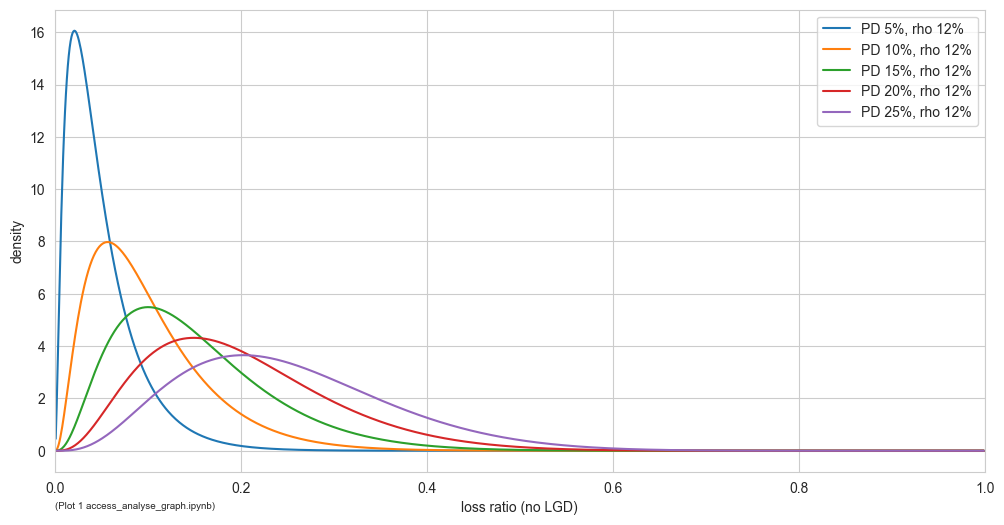

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.text(x=0, y=-2.2, s='(Plot 1 access_analyse_graph.ipynb)', fontweight='regular', fontsize=7)
sns.lineplot(data=create_df(0.05, rho=0.12), y='density', x='probability_CDF', label='PD 5%, rho 12%')
sns.lineplot(data=create_df(0.10, rho=0.12), y='density', x='probability_CDF', label='PD 10%, rho 12%')
sns.lineplot(data=create_df(0.15, rho=0.12), y='density', x='probability_CDF', label='PD 15%, rho 12%')
sns.lineplot(data=create_df(0.20, rho=0.12), y='density', x='probability_CDF', label='PD 20%, rho 12%')
sns.lineplot(data=create_df(0.25, rho=0.12), y='density', x='probability_CDF', label='PD 25%, rho 12%')
plt.xlim([0,1])
plt.xlabel("loss ratio (no LGD)")



Text(0.5, 0, 'loss ratio (no LGD)')

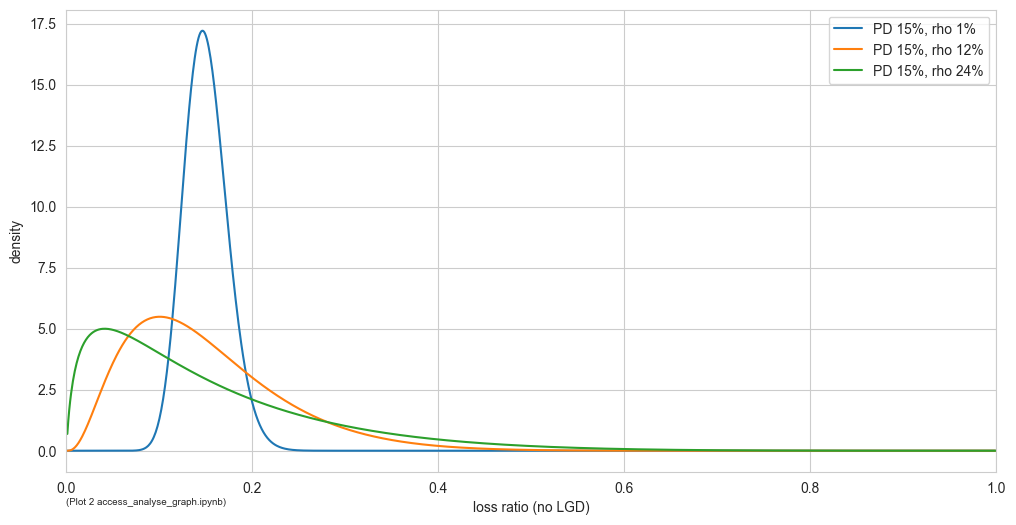

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.text(x=0, y=-2.2, s='(Plot 2 access_analyse_graph.ipynb)', fontweight='regular', fontsize=7)

sns.lineplot(data=create_df(0.15, rho=0.01), y='density', x='probability_CDF', label='PD 15%, rho 1%')
sns.lineplot(data=create_df(0.15, rho=0.12), y='density', x='probability_CDF', label='PD 15%, rho 12%')
sns.lineplot(data=create_df(0.15, rho=0.24), y='density', x='probability_CDF', label='PD 15%, rho 24%')

plt.xlim([0,1])
plt.xlabel("loss ratio (no LGD)")



Following columns in a dataframe ['Y']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


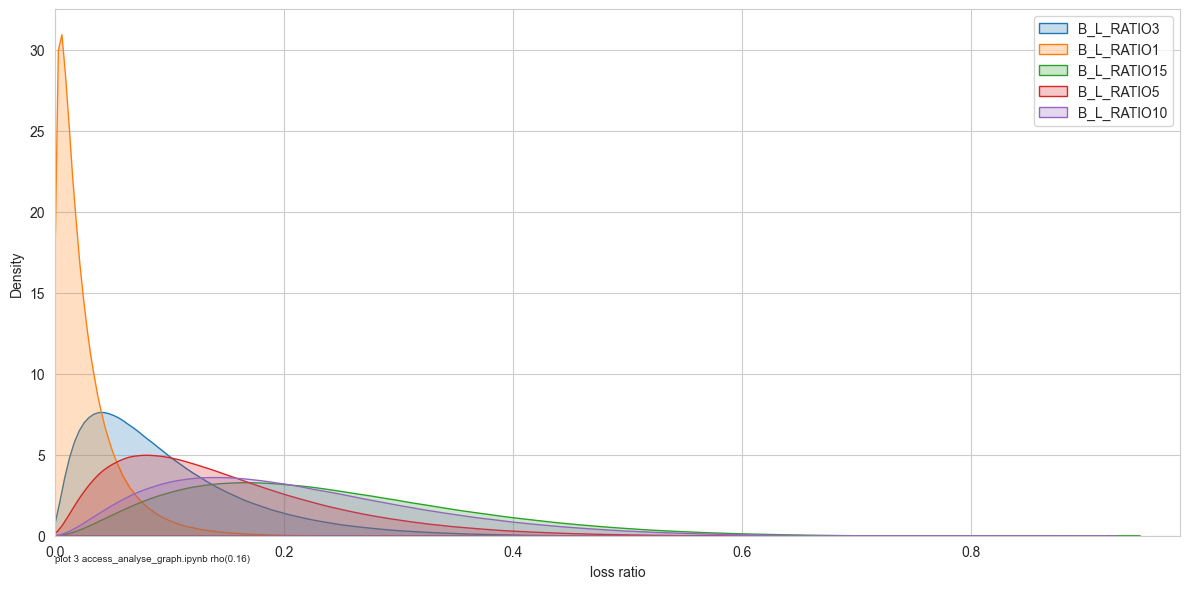

Following columns in a dataframe ['Y']
Following columns in a dataframe ['CCCtoC_L_RATIO']
Following columns in a dataframe ['CCCtoC_L_RATIO']
Following columns in a dataframe ['CCCtoC_L_RATIO']
Following columns in a dataframe ['CCCtoC_L_RATIO']
Following columns in a dataframe ['CCCtoC_L_RATIO']
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


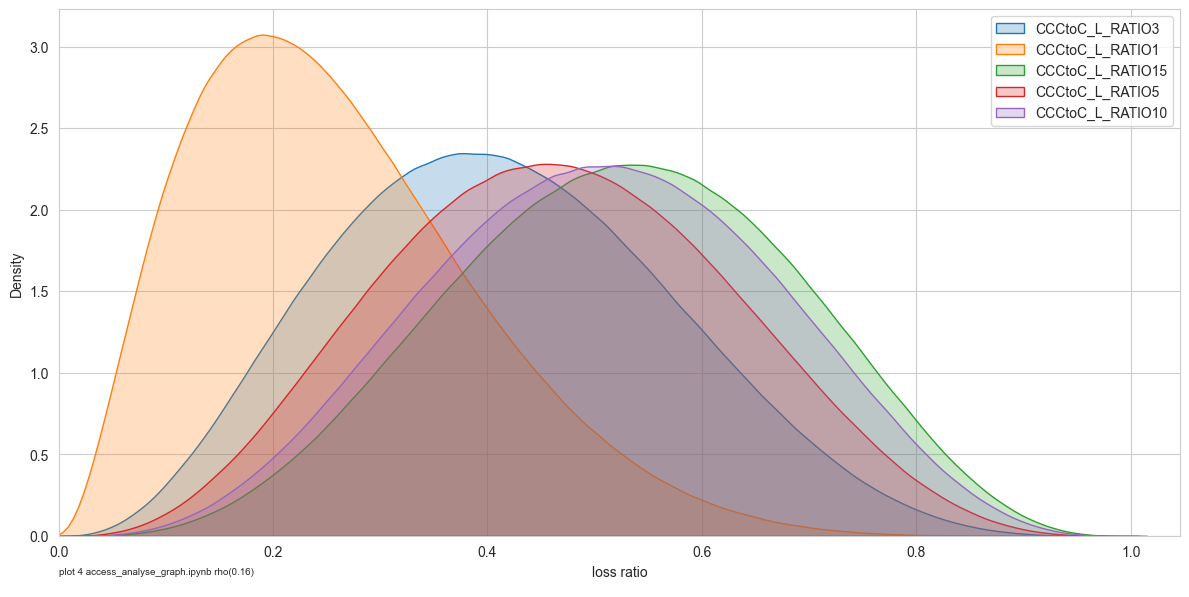

In [5]:
all_years_df = all_years_df_per_grade(db_file_paths_list_mid, "B_L_RATIO")
plot_all_in_df_kde_plot(all_years_df, "plot 3 access_analyse_graph.ipynb "+text_for_graphs_mid)
all_years_df = all_years_df_per_grade(db_file_paths_list_mid, "CCCtoC_L_RATIO")
plot_all_in_df_kde_plot(all_years_df, "plot 4 access_analyse_graph.ipynb "+text_for_graphs_mid, optional_text_y=-0.3)

del all_years_df

Following columns in a dataframe ['BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO']
"['Y'] not found in axis", continuing.. 
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


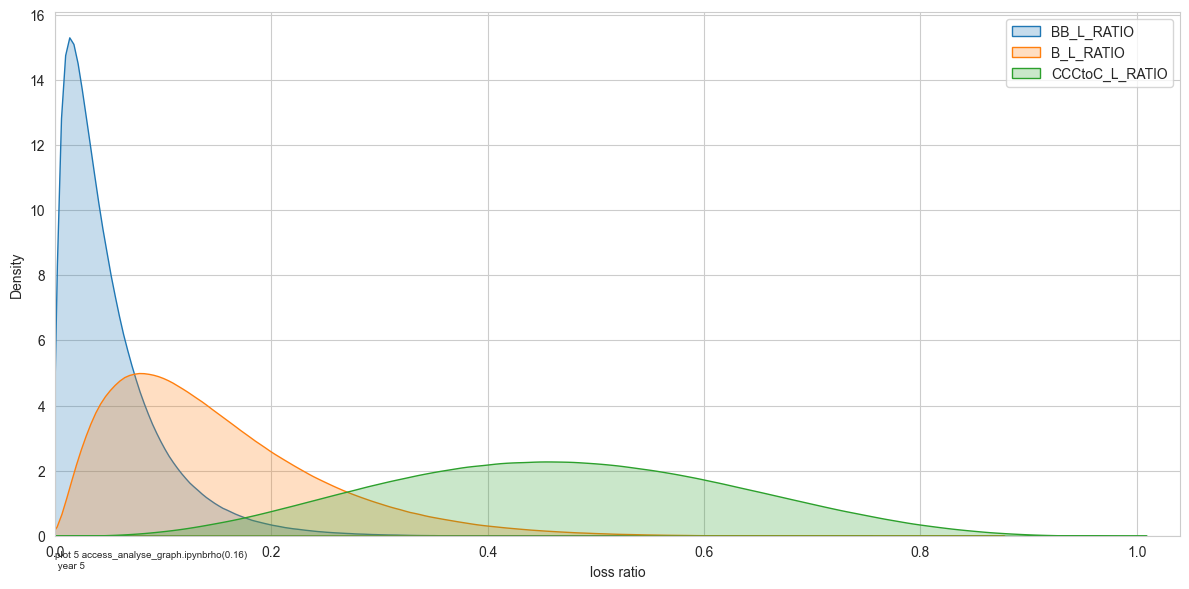

Following columns in a dataframe ['BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO']
"['Y'] not found in axis", continuing.. 
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


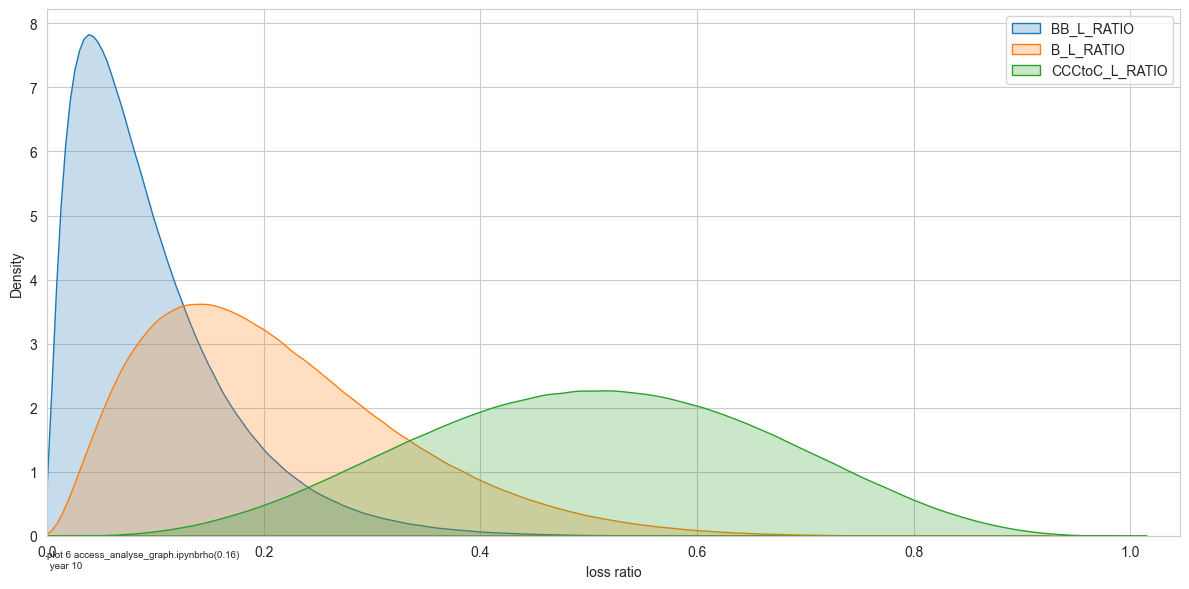

In [6]:
plot_all_in_df_kde_plot(fetch_table_data_to_df(db_file_paths_list_mid[3], 'SELECT BB_L_RATIO, B_L_RATIO, CCCtoC_L_RATIO '), "plot 5 access_analyse_graph.ipynb"+ text_for_graphs_mid+" year 5", optional_text_y=-1)
plot_all_in_df_kde_plot(fetch_table_data_to_df(db_file_paths_list_mid[4], 'SELECT BB_L_RATIO, B_L_RATIO, CCCtoC_L_RATIO '), "plot 6 access_analyse_graph.ipynb"+ text_for_graphs_mid+" year 10", optional_text_y=-0.5)


Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
"['Y'] not found in axis", continuing.. 
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


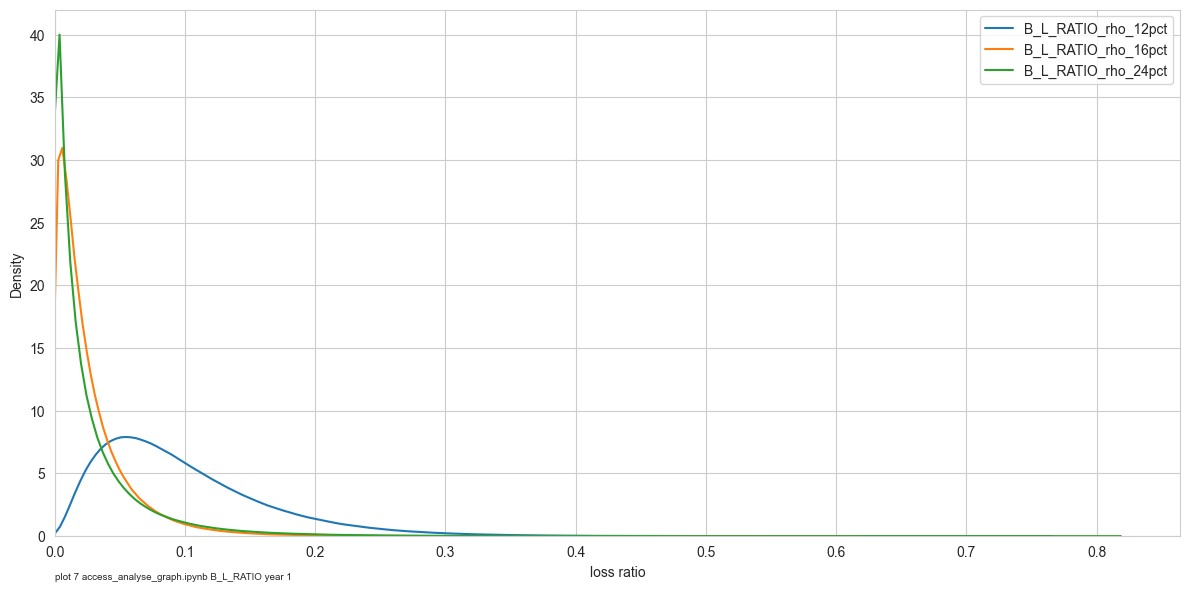

Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']
"['Y'] not found in axis", continuing.. 
"['S_ID'] not found in axis", continuing.. 


/var/folders/f5/vwxlnq1n4bzcs1bttnh2p_lw0000gn/T/ipykernel_89930/2895715649.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xlim([0, limit[0]+0.05])


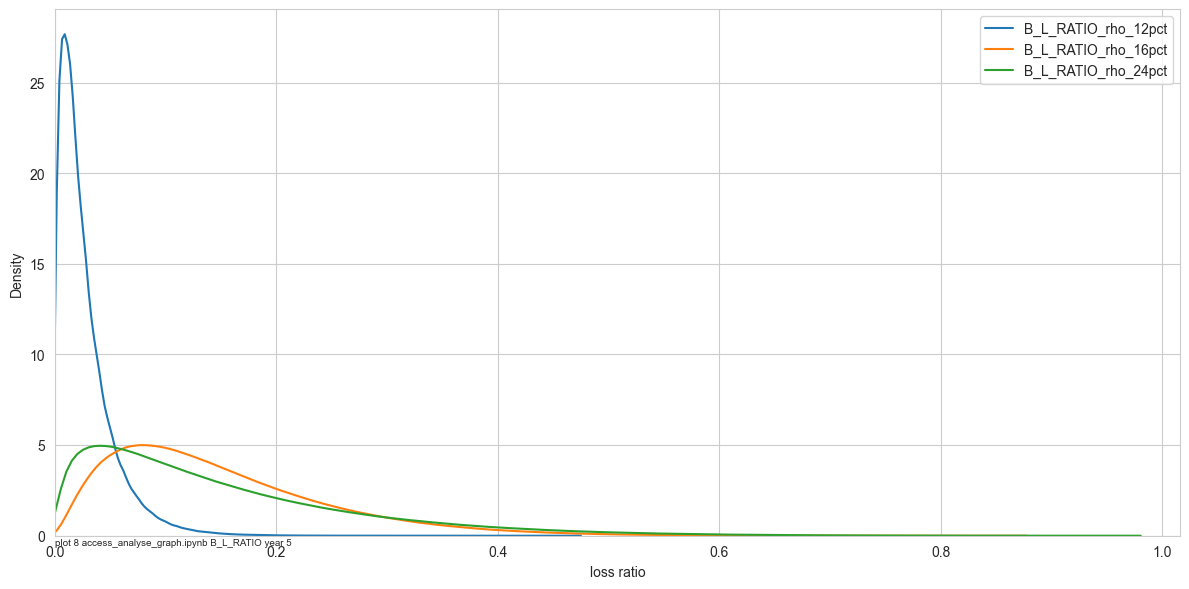

In [7]:
df = pd.DataFrame()
low = fetch_table_data_to_df(db_file_paths_list_low[1], 'SELECT B_L_RATIO')
mid = fetch_table_data_to_df(db_file_paths_list_mid[1], 'SELECT B_L_RATIO')
high = fetch_table_data_to_df(db_file_paths_list_high[1], 'SELECT B_L_RATIO')
df['B_L_RATIO_rho_12pct'] = low['B_L_RATIO']
df['B_L_RATIO_rho_16pct'] = mid['B_L_RATIO']
df['B_L_RATIO_rho_24pct'] = high['B_L_RATIO']
del low, mid, high
plot_all_in_df_kde_plot(df, 'plot 7 access_analyse_graph.ipynb B_L_RATIO year 1', optional_text_y=-3.5, fill=False)

df = pd.DataFrame()
low = fetch_table_data_to_df(db_file_paths_list_low[3], 'SELECT B_L_RATIO')
mid = fetch_table_data_to_df(db_file_paths_list_mid[3], 'SELECT B_L_RATIO')
high = fetch_table_data_to_df(db_file_paths_list_high[3], 'SELECT B_L_RATIO')
df['B_L_RATIO_rho_12pct'] = low['B_L_RATIO']
df['B_L_RATIO_rho_16pct'] = mid['B_L_RATIO']
df['B_L_RATIO_rho_24pct'] = high['B_L_RATIO']
del low, mid, high
plot_all_in_df_kde_plot(df, 'plot 8 access_analyse_graph.ipynb B_L_RATIO year 5', optional_text_y=-0.5, fill=False)

del df

In [8]:
midrhoVaR = allquantiles(0.999, db_file_paths_list_mid)

Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']


In [9]:
highrhoVaR = allquantiles(0.999, db_file_paths_list_high)

Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']


In [14]:
lowrhoVaR = allquantiles(0.999, db_file_paths_list_low)

Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']
Following columns in a dataframe ['S_ID', 'Y', 'AA_L_RATIO', 'A_L_RATIO', 'BBB_L_RATIO', 'BB_L_RATIO', 'B_L_RATIO', 'CCCtoC_L_RATIO', 'inv_grad_L_RATIO', 'spec_grad_L_RATIO']


In [15]:
EAD_i = 1000
LGD = 1-0.40
PORTFOLIO_SIZE = 500

low_var_number_df = apply_lambda_to_cols(lowrhoVaR, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)
mid_var_number_df = apply_lambda_to_cols(midrhoVaR, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)
high_var_number_df = apply_lambda_to_cols(highrhoVaR, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)



In [16]:
with open(CREDIT_RATING_FILEPATH, 'r') as f:
    whole_rating_list = json.load(f)
    dict2 = {}
    yearslist = [1, 3, 5, 10, 15]
    for year in yearslist:
        for i in whole_rating_list:
            if i['Year'] == year:
                parsed_ratings_list = {}
                for k in ['AA', 'A', 'BBB', 'BB', 'B', 'CCCtoC', 'inv_grad', 'spec_grad']:
                    pct = i[k] / 100  
                    parsed_ratings_list[k] = pct
                dict2[year] = parsed_ratings_list
                break


In [18]:
el_df = pd.DataFrame()
for i in dict2.keys():
    column_values = []    
    for j in dict2[i].keys():
        value = dict2[i][j] * EAD_i * PORTFOLIO_SIZE * LGD
        column_values.append(value)
    el_df[i] = pd.Series(column_values, index=dict2[i].keys())

In [32]:
def calculdf(df1, df2):
    new = pd.DataFrame(index=df1.index)
    for col in df1.columns: 
        new[col] = df1[str(col)].values - df2[int(col)].values
    return new

In [33]:
low_ul = calculdf(low_var_number_df,el_df)
mid_ul = calculdf(mid_var_number_df,el_df)
high_ul = calculdf(high_var_number_df,el_df)

In [44]:
el_df

,1,3,5,10,15
AA,60.0,240.0,1020.0,2520.0,3480.0
A,150.0,570.0,1200.0,3510.0,5130.0
BBB,420.0,1590.0,3420.0,7770.0,10920.0
BB,1350.0,8160.0,15510.0,28710.0,35790.0
B,8190.0,29370.0,44640.0,63450.0,70980.0
CCCtoC,77940.0,124260.0,139950.0,151920.0,157950.0
inv_grad,240.0,1140.0,2340.0,5160.0,7260.0
spec_grad,10560.0,28680.0,41100.0,57810.0,66360.0


In [36]:
low_ul

,3,1,15,5,10
AA_L_RATIO,4560.0,1740.0,27720.0,12180.0,22680.0
A_L_RATIO,8430.0,3450.0,35670.0,13800.0,28290.0
BBB_L_RATIO,16410.0,6780.0,56880.0,27780.0,46230.0
BB_L_RATIO,47640.0,14850.0,102210.0,69090.0,93090.0
B_L_RATIO,94230.0,47610.0,124620.0,110760.0,121950.0
CCCtoC_L_RATIO,122940.0,126060.0,109650.0,117450.0,112680.0
inv_grad_L_RATIO,13260.0,4560.0,44340.0,21660.0,36240.0
spec_grad_L_RATIO,93120.0,55440.0,123240.0,107700.0,119190.0


In [37]:
mid_ul

,3,1,15,5,10
AA_L_RATIO,5760.0,2340.0,36720.0,16380.0,29880.0
A_L_RATIO,10830.0,4050.0,46470.0,18000.0,36690.0
BBB_L_RATIO,21810.0,8580.0,71880.0,36180.0,59430.0
BB_L_RATIO,60840.0,19650.0,123210.0,86490.0,113490.0
B_L_RATIO,114630.0,61410.0,144420.0,131760.0,142950.0
CCCtoC_L_RATIO,137340.0,145860.0,119850.0,130050.0,123480.0
inv_grad_L_RATIO,17460.0,5760.0,56940.0,28260.0,46440.0
spec_grad_L_RATIO,113520.0,70440.0,143640.0,128700.0,140190.0


In [38]:
high_ul

,3,1,15,5,10
AA_L_RATIO,9360.0,3540.0,55320.0,25380.0,45480.0
A_L_RATIO,17430.0,6450.0,69270.0,28200.0,55890.0
BBB_L_RATIO,34410.0,13980.0,102480.0,54780.0,86430.0
BB_L_RATIO,89040.0,30450.0,160410.0,120090.0,150690.0
B_L_RATIO,151830.0,89010.0,175620.0,168360.0,175350.0
CCCtoC_L_RATIO,155940.0,175260.0,132450.0,145650.0,137280.0
inv_grad_L_RATIO,27660.0,9360.0,83340.0,43860.0,69240.0
spec_grad_L_RATIO,150720.0,101040.0,176040.0,165300.0,174390.0


In [39]:
low_var_number_df

,3,1,15,5,10
AA_L_RATIO,4800.0,1800.0,31200.0,13200.0,25200.0
A_L_RATIO,9000.0,3600.0,40800.0,15000.0,31800.0
BBB_L_RATIO,18000.0,7200.0,67800.0,31200.0,54000.0
BB_L_RATIO,55800.0,16200.0,138000.0,84600.0,121800.0
B_L_RATIO,123600.0,55800.0,195600.0,155400.0,185400.0
CCCtoC_L_RATIO,247200.0,204000.0,267600.0,257400.0,264600.0
inv_grad_L_RATIO,14400.0,4800.0,51600.0,24000.0,41400.0
spec_grad_L_RATIO,121800.0,66000.0,189600.0,148800.0,177000.0


In [40]:
mid_var_number_df

,3,1,15,5,10
AA_L_RATIO,6000.0,2400.0,40200.0,17400.0,32400.0
A_L_RATIO,11400.0,4200.0,51600.0,19200.0,40200.0
BBB_L_RATIO,23400.0,9000.0,82800.0,39600.0,67200.0
BB_L_RATIO,69000.0,21000.0,159000.0,102000.0,142200.0
B_L_RATIO,144000.0,69600.0,215400.0,176400.0,206400.0
CCCtoC_L_RATIO,261600.0,223800.0,277800.0,270000.0,275400.0
inv_grad_L_RATIO,18600.0,6000.0,64200.0,30600.0,51600.0
spec_grad_L_RATIO,142200.0,81000.0,210000.0,169800.0,198000.0


In [41]:
high_var_number_df

,3,1,15,5,10
AA_L_RATIO,9600.0,3600.0,58800.0,26400.0,48000.0
A_L_RATIO,18000.0,6600.0,74400.0,29400.0,59400.0
BBB_L_RATIO,36000.0,14400.0,113400.0,58200.0,94200.0
BB_L_RATIO,97200.0,31800.0,196200.0,135600.0,179400.0
B_L_RATIO,181200.0,97200.0,246600.0,213000.0,238800.0
CCCtoC_L_RATIO,280200.0,253200.0,290400.0,285600.0,289200.0
inv_grad_L_RATIO,28800.0,9600.0,90600.0,46200.0,74400.0
spec_grad_L_RATIO,179400.0,111600.0,242400.0,206400.0,232200.0


In [52]:
def theorethcialVaR_df(rho):
    df = pd.DataFrame()
    for i in dict2.keys():
        column_values = []    
        for j in dict2[i].keys():
            value = valueAtRisk(0.999,dict2[i][j],rho)
            column_values.append(value)
        df[i] = pd.Series(column_values, index=dict2[i].keys())
    return df


In [53]:
low_t_var = theorethcialVaR_df(0.12)
mid_t_var = theorethcialVaR_df(0.16)
high_t_var = theorethcialVaR_df(0.24)

In [55]:
low_t_var_cur = apply_lambda_to_cols(low_t_var, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)
mid_t_var_cur = apply_lambda_to_cols(mid_t_var, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)
high_t_var_cur = apply_lambda_to_cols(high_t_var, transformation=lambda x: x * EAD_i * PORTFOLIO_SIZE * LGD)



In [57]:
low_t_var_cur

,1,3,5,10,15
AA,1271.018217,3931.722692,12174.465116,23881.649657,30144.200916
A,2693.071353,7780.798650,13770.178646,30329.629434,39641.625247
BBB,6128.002513,17008.024057,29771.672333,52699.588477,66074.527531
BB,15047.661362,54466.035201,82782.729749,120210.060725,136250.815522
B,54600.457434,121799.673575,153685.773437,183886.896941,194020.283908
CCCtoC,202598.861619,245583.211304,256047.297231,262985.445803,266173.489714
inv_grad,3931.722692,13246.396569,22624.589575,39802.923436,50333.932751
spec_grad,64639.024023,120137.299088,147013.677654,175635.916556,187915.811185


In [58]:
mid_t_var_cur

,1,3,5,10,15
AA,1791.266714,5429.802172,16296.284256,31141.325592,38883.958566
A,3748.366246,10561.670527,18353.483631,39111.414659,50413.589301
BBB,8372.775687,22492.088511,38426.696237,65905.789306,81396.905936
BB,19991.822968,67972.581405,100270.519335,140821.634947,157516.669738
B,68129.590765,142494.024704,175209.202130,204726.048045,214297.961232
CCCtoC,222264.670797,260091.520870,268684.727231,274218.213384,276711.975941
inv_grad,5429.802172,17679.574187,29572.133590,50607.386256,63127.499174
spec_grad,79751.247251,140744.989386,168494.313939,196806.945300,208552.289895


In [59]:
high_t_var_cur

,1,3,5,10,15
AA,3017.265018,8944.638361,25697.344959,47150.181942,57854.215782
A,6233.504296,16998.393547,28754.718701,58164.291619,73282.736152
BBB,13599.114000,34817.036938,57230.130550,93167.438076,112186.872119
BB,31168.213414,95752.904974,134299.924996,178213.316809,194935.058938
B,95948.696975,179923.561084,211803.507554,237952.709899,245875.253561
CCCtoC,252249.762430,279484.464516,284853.111099,288110.163405,289520.881375
inv_grad,8944.638361,27756.536596,44943.733135,73537.245718,89667.745892
spec_grad,110204.864985,178134.748215,205505.058905,231187.637198,241153.516683


Following columns in a dataframe ['BB_L_RATIO']
Following columns in a dataframe ['B_L_RATIO']


Text(0.5, 0, 'loss ratio (no LGD)')

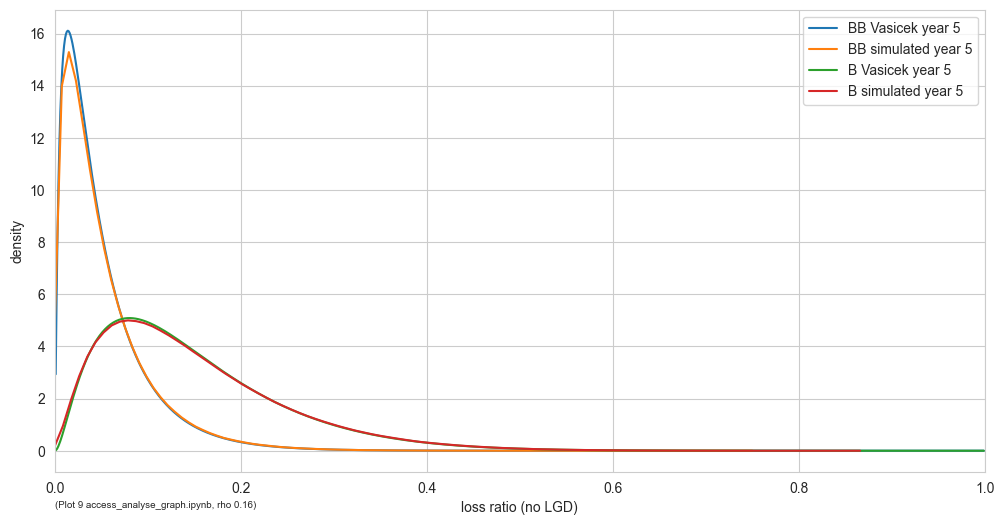

In [68]:
values = fetch_table_data_to_df(db_file_paths_list_mid[3], 'SELECT BB_L_RATIO')
data = values['BB_L_RATIO']
kde = gaussian_kde(data)
x_val = np.linspace(data.min(), data.max(), 100)
y_val = kde(x_val)
values['x'] = pd.DataFrame(x_val)
values['y'] = pd.DataFrame(y_val)

values2 = fetch_table_data_to_df(db_file_paths_list_mid[3], 'SELECT B_L_RATIO')
data2 = values2['B_L_RATIO']
kde2 = gaussian_kde(data2)
x_val2 = np.linspace(data2.min(), data2.max(), 100)
y_val2 = kde2(x_val2)
values2['x'] = pd.DataFrame(x_val2)
values2['y'] = pd.DataFrame(y_val2)



fig, ax = plt.subplots(figsize=(12, 6))
plt.text(x=0, y=-2.2, s='(Plot 9 access_analyse_graph.ipynb, rho 0.16)', fontweight='regular', fontsize=7)
sns.lineplot(data=create_df(0.0517, rho=0.16), y='density', x='probability_CDF', label='BB Vasicek year 5')
sns.lineplot(data=values, y='y', x='x', label='BB simulated year 5')
sns.lineplot(data=create_df(0.1488, rho=0.16), y='density', x='probability_CDF', label='B Vasicek year 5')
sns.lineplot(data=values2, y='y', x='x', label='B simulated year 5')

plt.xlim([0,1])
plt.xlabel("loss ratio (no LGD)")



